In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import cv2
from PIL import Image
import numpy as np
import argparse
import glob
import os

IMW = 320
IMH = 240

import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self, n_units1, n_units2):
        super(MLP, self).__init__()
        self.l1 = nn.Conv2d(3, n_units1, 5, stride=1, padding=2)
        #self.l2 = nn.Conv2d(n_units1, n_units2, 3, stride=1, padding=1)
        self.l3 = nn.Conv2d(n_units1, 1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = F.relu(self.l1(x))
        #x = F.relu(self.l2(x))
        x = self.l3(x)
        return torch.sigmoid(x)

def load_image(fname, imw, imh):
    #img = cv2.imread(fname)
    #img = cv2.resize(img, (imw, imh))
    img = Image.open(fname).resize((imw, imh))
    #plt.imshow(np.array(img))
    a = np.asarray(img).transpose(2,0,1).astype(np.float32)/255.
    return a, img

['./white_image/000435.jpg', './white_image/000200.jpg', './white_image/000670.jpg', './white_image/000087.jpg', './white_image/000480.jpg', './white_image/000113.jpg', './white_image/000051.jpg', './white_image/000283.jpg', './white_image/000660.jpg', './white_image/000279.jpg', './white_image/000600.jpg', './white_image/000540.jpg', './white_image/000022.jpg', './white_image/000126.jpg', './white_image/000109.jpg', './white_image/000258.jpg', './white_image/000071.jpg', './white_image/000129.jpg', './white_image/000270.jpg', './white_image/000146.jpg', './white_image/000757.jpg', './white_image/000333.jpg', './white_image/000112.jpg', './white_image/000650.jpg', './white_image/000148.jpg']
./white_image/000435_label.png
4542.0
./white_image/000200_label.png
3573.0
./white_image/000670_label.png
2396.0
./white_image/000087_label.png
3500.0
./white_image/000480_label.png
3577.0
./white_image/000113_label.png
3389.0
./white_image/000051_label.png
8723.0
./white_image/000283_label.png
25

<ipython-input-2-572d9e6bd62f>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


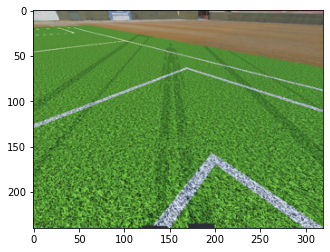

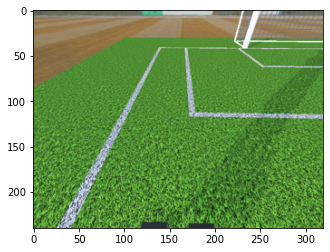

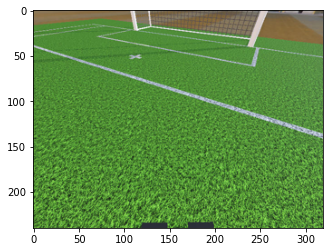

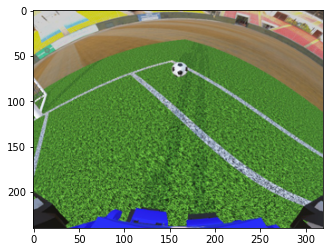

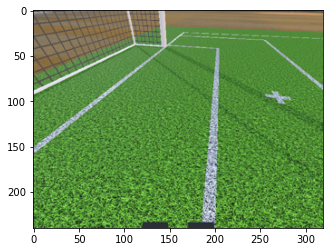

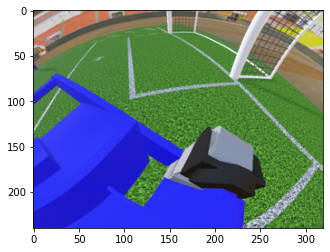

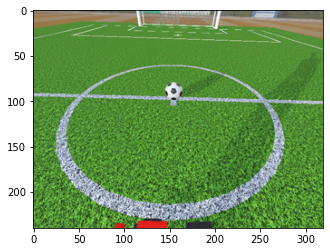

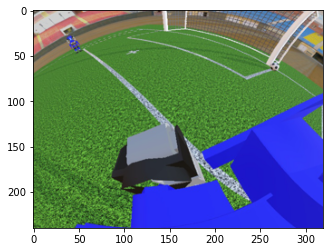

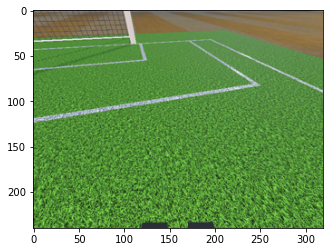

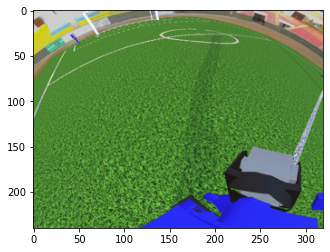

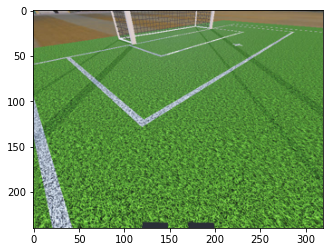

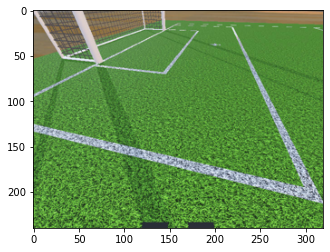

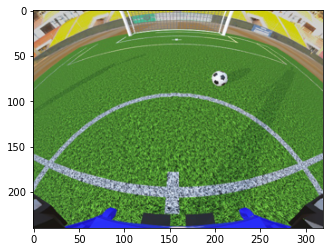

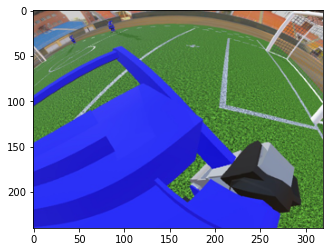

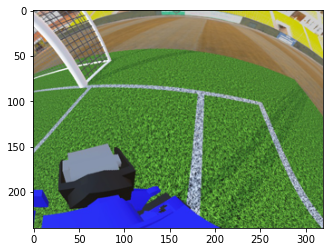

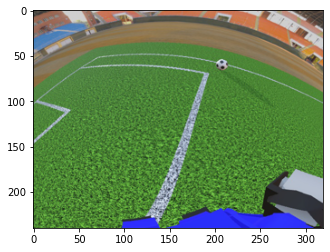

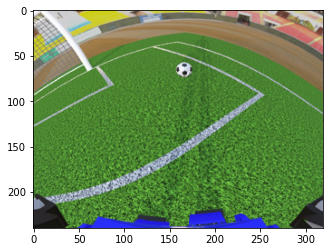

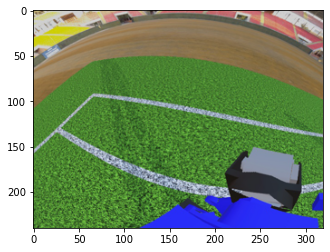

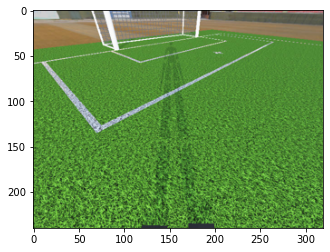

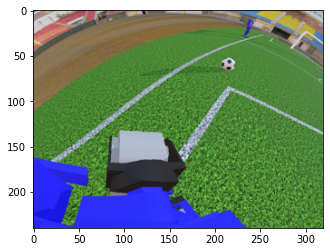

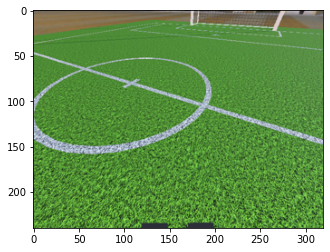

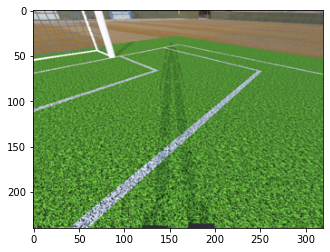

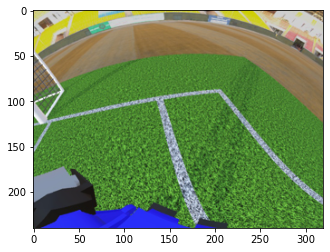

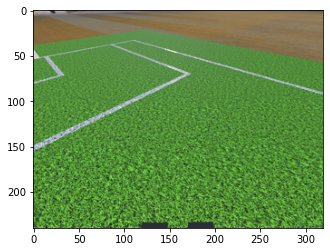

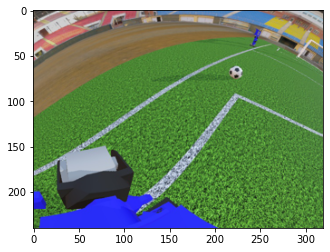

In [2]:
class WhitelineDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        imw = IMW
        imh = IMH
        x = np.zeros((0, 3, imh, imw), dtype=np.float32)
        t = np.zeros((0, 1, imh, imw), dtype=np.float32)
        jpgfiles = glob.glob(image_dir + '*.jpg')
        print(jpgfiles)
        for f in jpgfiles:
            plt.figure()
            a, img = load_image(f, imw, imh)
            a1 = np.expand_dims(a,axis=0)
            x = np.append(x, a1, axis=0)
            #im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #timg = Image.fromarray(im_rgb)
            plt.imshow(img)
            
            lfile = os.path.splitext(f)[0] + '_label.png'
            print(lfile)
            im_gray = cv2.imread(lfile, cv2.IMREAD_GRAYSCALE)
            im_gray = cv2.resize(im_gray, (imw, imh))
            #plt.figure()
            #plt.imshow(timg)
            a = np.asarray(im_gray).astype(np.float32) > 0.01
            a = a.astype(np.float32)
            print(np.sum(a))
            a1 = np.expand_dims(a,axis=0)
            a1 = np.expand_dims(a1,axis=0)
            t = np.append(t, a1, axis=0)
        self.data  = x
        self.label = t

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #print(self.data.shape)
        #print(self.label.shape)
        images =  self.data[idx, :, :, :]
        labels = self.label[idx, :, :]

        return (images, labels)


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

parser = argparse.ArgumentParser()
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--dry-run', action='store_true', default=False,
                    help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
args = parser.parse_args(args=[])
dataset = WhitelineDataset('./white_image/')
train_loader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=0)


In [3]:
# exec training
def train(args, model, device, dataloader, optimizer, epoch):
    model.train()
    lossfun = nn.BCELoss()
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = lossfun(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item()))
            if args.dry_run:
                break

model = MLP(4, 2).to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr, weight_decay=0.001)
model.to(device)

# 繰り返し数は要調整
# Lossが0.05くらいまで下がるはず（下がらなかったらやり直す）
for i in range(1000):
    train(args, model=model, device=device, dataloader=train_loader, optimizer=optimizer, epoch=i)

# save to file
cpu = torch.device("cpu")
model.to(cpu)
torch.save(model.state_dict(), "wl_model.pt")

Train Epoch: 0 [0/25 (0%)]	Loss: 0.556070
Train Epoch: 1 [0/25 (0%)]	Loss: 0.485414
Train Epoch: 2 [0/25 (0%)]	Loss: 0.440361
Train Epoch: 3 [0/25 (0%)]	Loss: 0.383292
Train Epoch: 4 [0/25 (0%)]	Loss: 0.358995
Train Epoch: 5 [0/25 (0%)]	Loss: 0.336511
Train Epoch: 6 [0/25 (0%)]	Loss: 0.268030
Train Epoch: 7 [0/25 (0%)]	Loss: 0.307616
Train Epoch: 8 [0/25 (0%)]	Loss: 0.250987
Train Epoch: 9 [0/25 (0%)]	Loss: 0.254256
Train Epoch: 10 [0/25 (0%)]	Loss: 0.253553
Train Epoch: 11 [0/25 (0%)]	Loss: 0.216465
Train Epoch: 12 [0/25 (0%)]	Loss: 0.256002
Train Epoch: 13 [0/25 (0%)]	Loss: 0.225217
Train Epoch: 14 [0/25 (0%)]	Loss: 0.218029
Train Epoch: 15 [0/25 (0%)]	Loss: 0.233094
Train Epoch: 16 [0/25 (0%)]	Loss: 0.263294
Train Epoch: 17 [0/25 (0%)]	Loss: 0.199850
Train Epoch: 18 [0/25 (0%)]	Loss: 0.223873
Train Epoch: 19 [0/25 (0%)]	Loss: 0.256107
Train Epoch: 20 [0/25 (0%)]	Loss: 0.240571
Train Epoch: 21 [0/25 (0%)]	Loss: 0.264352
Train Epoch: 22 [0/25 (0%)]	Loss: 0.249391
Train Epoch: 23 [0/25

Train Epoch: 190 [0/25 (0%)]	Loss: 0.090957
Train Epoch: 191 [0/25 (0%)]	Loss: 0.103932
Train Epoch: 192 [0/25 (0%)]	Loss: 0.124966
Train Epoch: 193 [0/25 (0%)]	Loss: 0.117753
Train Epoch: 194 [0/25 (0%)]	Loss: 0.103658
Train Epoch: 195 [0/25 (0%)]	Loss: 0.125738
Train Epoch: 196 [0/25 (0%)]	Loss: 0.076501
Train Epoch: 197 [0/25 (0%)]	Loss: 0.141992
Train Epoch: 198 [0/25 (0%)]	Loss: 0.112680
Train Epoch: 199 [0/25 (0%)]	Loss: 0.123372
Train Epoch: 200 [0/25 (0%)]	Loss: 0.079473
Train Epoch: 201 [0/25 (0%)]	Loss: 0.108151
Train Epoch: 202 [0/25 (0%)]	Loss: 0.105860
Train Epoch: 203 [0/25 (0%)]	Loss: 0.124561
Train Epoch: 204 [0/25 (0%)]	Loss: 0.140751
Train Epoch: 205 [0/25 (0%)]	Loss: 0.085937
Train Epoch: 206 [0/25 (0%)]	Loss: 0.116114
Train Epoch: 207 [0/25 (0%)]	Loss: 0.105282
Train Epoch: 208 [0/25 (0%)]	Loss: 0.093458
Train Epoch: 209 [0/25 (0%)]	Loss: 0.082598
Train Epoch: 210 [0/25 (0%)]	Loss: 0.094674
Train Epoch: 211 [0/25 (0%)]	Loss: 0.071975
Train Epoch: 212 [0/25 (0%)]	Los

Train Epoch: 382 [0/25 (0%)]	Loss: 0.091485
Train Epoch: 383 [0/25 (0%)]	Loss: 0.104908
Train Epoch: 384 [0/25 (0%)]	Loss: 0.148382
Train Epoch: 385 [0/25 (0%)]	Loss: 0.077870
Train Epoch: 386 [0/25 (0%)]	Loss: 0.109944
Train Epoch: 387 [0/25 (0%)]	Loss: 0.094160
Train Epoch: 388 [0/25 (0%)]	Loss: 0.128029
Train Epoch: 389 [0/25 (0%)]	Loss: 0.091410
Train Epoch: 390 [0/25 (0%)]	Loss: 0.123196
Train Epoch: 391 [0/25 (0%)]	Loss: 0.103409
Train Epoch: 392 [0/25 (0%)]	Loss: 0.129963
Train Epoch: 393 [0/25 (0%)]	Loss: 0.128922
Train Epoch: 394 [0/25 (0%)]	Loss: 0.101145
Train Epoch: 395 [0/25 (0%)]	Loss: 0.091737
Train Epoch: 396 [0/25 (0%)]	Loss: 0.123197
Train Epoch: 397 [0/25 (0%)]	Loss: 0.128311
Train Epoch: 398 [0/25 (0%)]	Loss: 0.071033
Train Epoch: 399 [0/25 (0%)]	Loss: 0.119456
Train Epoch: 400 [0/25 (0%)]	Loss: 0.081952
Train Epoch: 401 [0/25 (0%)]	Loss: 0.110864
Train Epoch: 402 [0/25 (0%)]	Loss: 0.082794
Train Epoch: 403 [0/25 (0%)]	Loss: 0.086219
Train Epoch: 404 [0/25 (0%)]	Los

Train Epoch: 574 [0/25 (0%)]	Loss: 0.103157
Train Epoch: 575 [0/25 (0%)]	Loss: 0.115235
Train Epoch: 576 [0/25 (0%)]	Loss: 0.140787
Train Epoch: 577 [0/25 (0%)]	Loss: 0.116186
Train Epoch: 578 [0/25 (0%)]	Loss: 0.139896
Train Epoch: 579 [0/25 (0%)]	Loss: 0.099332
Train Epoch: 580 [0/25 (0%)]	Loss: 0.124503
Train Epoch: 581 [0/25 (0%)]	Loss: 0.072368
Train Epoch: 582 [0/25 (0%)]	Loss: 0.073482
Train Epoch: 583 [0/25 (0%)]	Loss: 0.160425
Train Epoch: 584 [0/25 (0%)]	Loss: 0.077840
Train Epoch: 585 [0/25 (0%)]	Loss: 0.126537
Train Epoch: 586 [0/25 (0%)]	Loss: 0.110078
Train Epoch: 587 [0/25 (0%)]	Loss: 0.088432
Train Epoch: 588 [0/25 (0%)]	Loss: 0.095576
Train Epoch: 589 [0/25 (0%)]	Loss: 0.096432
Train Epoch: 590 [0/25 (0%)]	Loss: 0.118123
Train Epoch: 591 [0/25 (0%)]	Loss: 0.092812
Train Epoch: 592 [0/25 (0%)]	Loss: 0.134627
Train Epoch: 593 [0/25 (0%)]	Loss: 0.099877
Train Epoch: 594 [0/25 (0%)]	Loss: 0.102083
Train Epoch: 595 [0/25 (0%)]	Loss: 0.077542
Train Epoch: 596 [0/25 (0%)]	Los

Train Epoch: 766 [0/25 (0%)]	Loss: 0.113333
Train Epoch: 767 [0/25 (0%)]	Loss: 0.119655
Train Epoch: 768 [0/25 (0%)]	Loss: 0.091763
Train Epoch: 769 [0/25 (0%)]	Loss: 0.099995
Train Epoch: 770 [0/25 (0%)]	Loss: 0.110946
Train Epoch: 771 [0/25 (0%)]	Loss: 0.123775
Train Epoch: 772 [0/25 (0%)]	Loss: 0.123580
Train Epoch: 773 [0/25 (0%)]	Loss: 0.081784
Train Epoch: 774 [0/25 (0%)]	Loss: 0.102194
Train Epoch: 775 [0/25 (0%)]	Loss: 0.088425
Train Epoch: 776 [0/25 (0%)]	Loss: 0.117098
Train Epoch: 777 [0/25 (0%)]	Loss: 0.097545
Train Epoch: 778 [0/25 (0%)]	Loss: 0.090009
Train Epoch: 779 [0/25 (0%)]	Loss: 0.098741
Train Epoch: 780 [0/25 (0%)]	Loss: 0.102992
Train Epoch: 781 [0/25 (0%)]	Loss: 0.112303
Train Epoch: 782 [0/25 (0%)]	Loss: 0.055556
Train Epoch: 783 [0/25 (0%)]	Loss: 0.077948
Train Epoch: 784 [0/25 (0%)]	Loss: 0.131753
Train Epoch: 785 [0/25 (0%)]	Loss: 0.086087
Train Epoch: 786 [0/25 (0%)]	Loss: 0.074559
Train Epoch: 787 [0/25 (0%)]	Loss: 0.130068
Train Epoch: 788 [0/25 (0%)]	Los

Train Epoch: 958 [0/25 (0%)]	Loss: 0.068196
Train Epoch: 959 [0/25 (0%)]	Loss: 0.083358
Train Epoch: 960 [0/25 (0%)]	Loss: 0.073429
Train Epoch: 961 [0/25 (0%)]	Loss: 0.076810
Train Epoch: 962 [0/25 (0%)]	Loss: 0.053741
Train Epoch: 963 [0/25 (0%)]	Loss: 0.081117
Train Epoch: 964 [0/25 (0%)]	Loss: 0.063713
Train Epoch: 965 [0/25 (0%)]	Loss: 0.073923
Train Epoch: 966 [0/25 (0%)]	Loss: 0.060984
Train Epoch: 967 [0/25 (0%)]	Loss: 0.087714
Train Epoch: 968 [0/25 (0%)]	Loss: 0.061072
Train Epoch: 969 [0/25 (0%)]	Loss: 0.060453
Train Epoch: 970 [0/25 (0%)]	Loss: 0.063532
Train Epoch: 971 [0/25 (0%)]	Loss: 0.064020
Train Epoch: 972 [0/25 (0%)]	Loss: 0.075334
Train Epoch: 973 [0/25 (0%)]	Loss: 0.077036
Train Epoch: 974 [0/25 (0%)]	Loss: 0.063149
Train Epoch: 975 [0/25 (0%)]	Loss: 0.066673
Train Epoch: 976 [0/25 (0%)]	Loss: 0.051033
Train Epoch: 977 [0/25 (0%)]	Loss: 0.072052
Train Epoch: 978 [0/25 (0%)]	Loss: 0.056291
Train Epoch: 979 [0/25 (0%)]	Loss: 0.074310
Train Epoch: 980 [0/25 (0%)]	Los

In [4]:
# load model from file
model_path = "wl_model.pt"

model = MLP(4, 2)
model.load_state_dict(torch.load(model_path))
model.eval()

def eval_image(fname, thre):
    imw = IMW
    imh = IMH
    testx = np.zeros((0, 3, imh, imw), dtype=np.float32)

    a, img = load_image(fname, imw, imh)
    a1 = np.expand_dims(a,axis=0)
    #print(a1.shape)
    testx = np.append(testx, a1, axis=0)

    import time
    t0 = time.time()
    testy = model(torch.FloatTensor(testx))
    print('forward time [s]: ' + str(time.time()-t0))

    #fig, axs = plt.subplots(1,3)
    #plt.imshow(img, ax=axs[0])
    imd = Image.new('RGB', (imw*2, imh))
    imd.paste(img)
    thimg = (testy.detach().to(cpu).numpy()[0][0] > thre) * 255
    print(thimg.shape)
    print(f'max {np.max(thimg)}')
    print(f'min {np.min(thimg)}')
    thimg = thimg.astype(np.uint8)
    
    thimg = Image.fromarray(thimg)
    plt.imshow(thimg)

    imd.paste(thimg, (imw, 0))
    plt.imshow(imd)

forward time [s]: 0.001155853271484375
(240, 320)
max 255
min 0


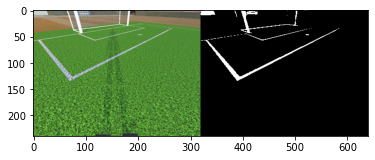

In [5]:
eval_image('white_image/000270.jpg', 0.5)

forward time [s]: 0.0009927749633789062
(240, 320)
max 255
min 0


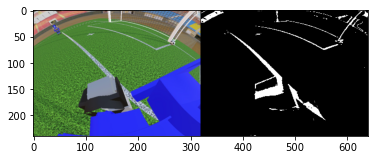

In [6]:
eval_image('white_image/000283.jpg', 0.5)

In [7]:
#scripted_model = torch.jit.script(model)
#print(model)
#scripted_model.save("traced_wl_model.pt")

In [8]:
# save torchscript for C++
a, img = load_image('white_image/000283.jpg', IMW, IMH)
#a1 = np.expand_dims(a,axis=0)
ex = np.expand_dims(a,axis=0)
traced_script_module = torch.jit.trace(model, torch.FloatTensor(ex))
traced_script_module.save("traced_wl_model.pt") # これをC++から呼び出す